https://www.kaggle.com/code/kanncaa1/recurrent-neural-network-with-pytorch/notebook 

https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_recurrent_neuralnetwork/#3-building-a-recurrent-neural-network-with-pytorch-gpu

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("input/"))

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'test.csv', 'train.csv']


In [2]:
# Import Libraries
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [3]:
# check if we speed up computation by using a gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

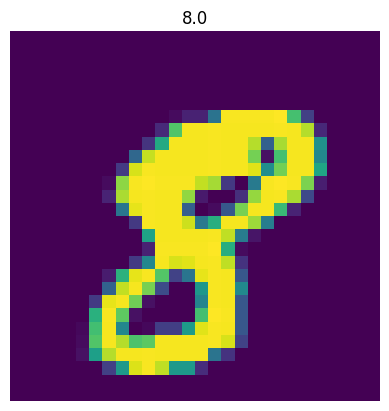

In [4]:
# Prepare Dataset
# load data
train = pd.read_csv(r"input/train.csv",dtype = np.float32)

# split data into features(pixels) and labels(numbers from 0 to 9)
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255 # normalization

# train test split. Size of train data is 80% and size of test data is 20%. 
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42) 

# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

# batch_size, epoch and iteration
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = TensorDataset(featuresTrain,targetsTrain)
test = TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

# visualize one of the images in data set
plt.imshow(features_numpy[10].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[10]))
plt.savefig('graph.png')
plt.show()

In [5]:
# Create RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # RNN
        """
        nn.RNN inputs: input_size, hidden_size, num_layers, nonlinearity, bias, batch_first, dropout, bidirectional
        """
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        
        # Initialize hidden state with zeros
        """
        For batches, h0 should be of shape (N,L,H_in)
        N = batch size
        L = sequence length
        H_in = input_size
        """
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)).to(device)
            
        # One time step
        out, hn = self.rnn(x, h0.detach())
        # print(out[0,:,0])
        out = self.fc(out[:, -1, :]) # only care about the final output making this a multi input, single output RNN
        return out

# batch_size, epoch and iteration
batch_size = 100
n_iters = 8000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = TensorDataset(featuresTrain,targetsTrain)
test = TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)
    
# Create RNN

""" 
Based on their input dimensions, what makes this a recurrent neural network is the fact that the input dimenions
is only 28 but each image is 28x28. Thus for a single image, it is a sequence of length 28, each input being a size of 28
"""

input_dim = 28    # input dimension
hidden_dim = 100  # hidden layer dimension
layer_dim = 1     # number of hidden layers
output_dim = 10   # output dimension

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

model.to(device) # send to gpu

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [6]:
temp = torch.from_numpy(features_numpy[10]).view(-1, 28, 28)
print("new shape: {}".format(temp.shape))

new shape: torch.Size([1, 28, 28])


In [7]:
seq_dim = 28  
loss_list = []
iteration_list = []
accuracy_list = []
count = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        train  = Variable(images.view(-1, seq_dim, input_dim)).requires_grad_().to(device)
        labels = Variable(labels).to(device)
            
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        if count % 250 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images = Variable(images.view(-1, seq_dim, input_dim)).to(device)

                # Forward propagation
                outputs = model(images)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += labels.size(0)
                
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            if count % 500 == 0:
                # Print Loss
                # print(labels.shape)
                # print(train.shape)
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data.item(), accuracy))

Iteration: 500  Loss: 1.7416080236434937  Accuracy: 34.35714340209961 %
Iteration: 1000  Loss: 0.9148966073989868  Accuracy: 64.52381134033203 %
Iteration: 1500  Loss: 0.5157349109649658  Accuracy: 82.63095092773438 %
Iteration: 2000  Loss: 0.41935333609580994  Accuracy: 86.80952453613281 %
Iteration: 2500  Loss: nan  Accuracy: 9.714285850524902 %
Iteration: 3000  Loss: nan  Accuracy: 9.714285850524902 %
Iteration: 3500  Loss: nan  Accuracy: 9.714285850524902 %
Iteration: 4000  Loss: nan  Accuracy: 9.714285850524902 %
Iteration: 4500  Loss: nan  Accuracy: 9.714285850524902 %
Iteration: 5000  Loss: nan  Accuracy: 9.714285850524902 %
Iteration: 5500  Loss: nan  Accuracy: 9.714285850524902 %
Iteration: 6000  Loss: nan  Accuracy: 9.714285850524902 %
Iteration: 6500  Loss: nan  Accuracy: 9.714285850524902 %
Iteration: 7000  Loss: nan  Accuracy: 9.714285850524902 %
Iteration: 7500  Loss: nan  Accuracy: 9.714285850524902 %


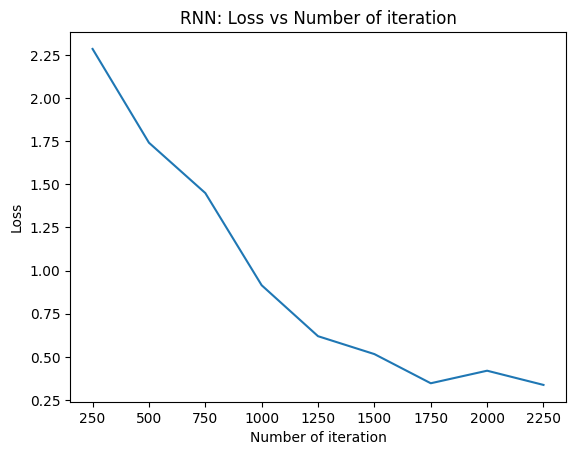

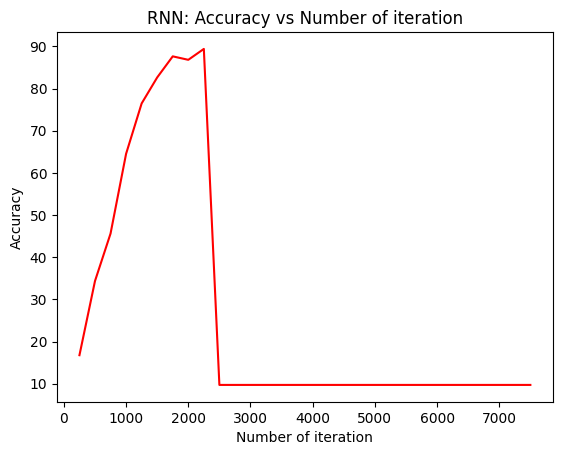

In [8]:
# visualization loss 
loss_list = [loss.cpu() for loss in loss_list]
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("RNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("RNN: Accuracy vs Number of iteration")
plt.savefig('graph.png')
plt.show()

In [3]:
import hub
ds = hub.load("hub://activeloop/spoken_mnist")

/home/jorgejc2/.local/lib/python3.8/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (3.2.16) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


hub://activeloop/spoken_mnist loaded successfully.

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/spoken_mnist



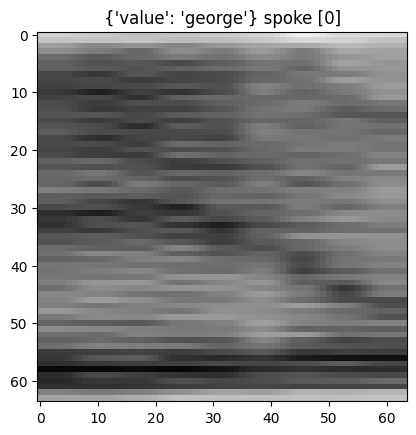

total audios: 3000
(2384,)


In [4]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
from IPython.display import Audio
from scipy import signal
import numpy as np
import build.pybind_modules.dsp_module as cu
import build.pybind_modules.matrix_module as myMatrix
plt.imshow(ds.spectrograms[0].numpy())
plt.title(f"{ds.speakers[0].data()} spoke {ds.labels[0].numpy()}")
plt.show()

print("total audios: {}".format(len(ds.audio)))

a = ds.audio[0].numpy().T[0]
print(a.shape)
fs = 8000
Audio(a, rate=fs)
# fs, music = wavfile.read()

In [5]:
ds = None

In [6]:
nfft = 512
noverlap = -1
nfilt = 40
num_ceps = 13
t_time = len(a) / fs
min_frames = -1
max_frames = -1
max_frames_idx = 0
for i in range(len(ds.audio)-1000):
    a = ds.audio[i].numpy().T[0]
    ceps = np.array(myMatrix.MFCC_Matrix(list(a), fs, nfft, noverlap, 2, 0.6, nfilt, num_ceps), copy=False)
    ceps = ceps[1:,:]
    t = np.linspace(0, t_time, ceps.shape[1])
    n = np.arange(num_ceps-1)
    if min_frames == -1 or ceps.shape[1] < min_frames:
        min_frames = ceps.shape[1]
    if max_frames == -1 or ceps.shape[1] > max_frames:
        max_frames = ceps.shape[1]
        max_frames_idx = i

print(ceps.shape)

plt.title("Spectrum of c(n)")
plt.ylabel("Cepstral Coefficients")
plt.xlabel("Time (sec)")
plt.pcolormesh(t, n, ceps)
plt.colorbar(format="%+2.f dB")

AttributeError: 'NoneType' object has no attribute 'audio'

3
40
1047


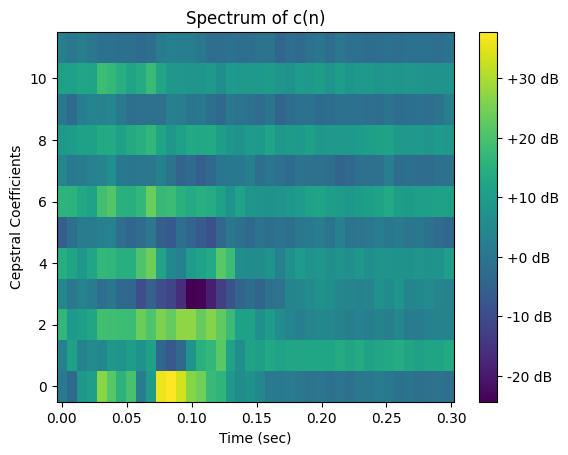

In [12]:
print(min_frames)
print(max_frames)
print(max_frames_idx)
a = ds.audio[max_frames_idx].numpy().T[0]
ceps = np.array(myMatrix.MFCC_Matrix(list(a), fs, nfft, noverlap, 2, 0.6, nfilt, num_ceps), copy=False)
ceps = ceps[1:,:]
t = np.linspace(0, t_time, ceps.shape[1])
n = np.arange(num_ceps-1)
plt.title("Spectrum of c(n)")
plt.ylabel("Cepstral Coefficients")
plt.xlabel("Time (sec)")
plt.pcolormesh(t, n, ceps)
plt.colorbar(format="%+2.f dB")

Audio(a, rate=fs)

#### Digit Recognizer

Testing a neural network for digit recognition for future reference

In [7]:
import torch
import torch.nn as nn
# import torch.nn.functional as F
import torch.optim as optim
# from utils import get_dataset_from_arrays
from torch.utils.data import DataLoader
from torch.autograd import Variable
import random
import librosa

In [8]:
# Check if GPU is available
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu" # FORCE to run on cpu for simpler debugging

In [15]:
"""
Process and organize data from deeplake data set
"""
# fs = 8000
# nfft = 512
# noverlap = -1
# nfilt = 40
# num_ceps = 13
# nn_data_cols = 48
# nn_data_rows = 12

# ratio = 0.8
# train_set_size = int(len(ds.audio) * ratio)
# dev_set_size = int(len(ds.audio) * (1 - ratio))

# # initialize arrays to hold processed data
# l_train_set = []
# l_train_labels = []
# l_dev_set = []
# l_dev_set_labels = []

# # randomize access into audio files
# random.seed(9001)
# randomized_data = random.sample(range(len(ds.audio)), len(ds.audio))
# train_indices = randomized_data[:train_set_size]
# dev_indices = randomized_data[train_set_size:]

# for i in range(train_set_size):
#     curr_data_idx = train_indices[i]
#     sig = ds.audio[curr_data_idx].numpy().T[0]
#     l_train_set.append(np.array(myMatrix.MFCC_Matrix(list(sig), fs, nfft, noverlap, 2, 0.6, nfilt, num_ceps), copy=False)[1:,:].ravel())
#     l_train_labels.append(ds.labels[curr_data_idx].numpy()[0])

# for i in range(dev_set_size):
#     curr_data_idx = dev_indices[i]
#     sig = ds.audio[curr_data_idx].numpy().T[0]
#     l_dev_set.append(np.array(myMatrix.MFCC_Matrix(list(sig), fs, nfft, noverlap, 2, 0.6, nfilt, num_ceps), copy=False)[1:,:].ravel())
#     l_dev_set_labels.append(ds.labels[curr_data_idx].numpy()[0])

# train_set = np.zeros((train_set_size,nn_data_rows*nn_data_cols))
# dev_set = np.zeros((dev_set_size,nn_data_rows*nn_data_cols))
# l_train_labels = np.array(l_train_labels, dtype=np.int64)
# l_dev_set_labels = np.array(l_dev_set_labels, dtype=np.int64)

# # append zeros or trim data in order to fulfull nn_data_cols requirement
# for i in range(len(l_train_set)):
#     curr_sig = l_train_set[i]
#     if len(curr_sig) > nn_data_cols*nn_data_rows:
#         train_set[i] = curr_sig[:nn_data_cols*nn_data_rows]
#     elif len(curr_sig) < nn_data_cols*nn_data_rows:
#         train_set[i] = np.resize(curr_sig, (nn_data_rows, nn_data_cols)).ravel()
#     else:
#         train_set[i] = curr_sig

# for i in range(len(l_dev_set)):
#     curr_sig = l_dev_set[i]
#     if len(curr_sig) > nn_data_cols*nn_data_rows:
#         dev_set[i] = curr_sig[:nn_data_cols*nn_data_rows]
#     elif len(curr_sig) < nn_data_cols*nn_data_rows:
#         dev_set[i] = np.resize(curr_sig, (nn_data_rows, nn_data_cols)).ravel()
#     else:
#         dev_set[i] = curr_sig




'\nProcess and organize data from deeplake data set\n'

In [9]:
# curr_dir = os.getcwd() + '/' + 'AudioMNIST/data/'
# dir_list = os.listdir(curr_dir) 
# dir_list = [label for label in dir_list if '.' not in label] # only files have . in them, directories should not
# print(curr_dir) # prints the current directory
# print(dir_list)
# print(len(dir_list))
# set_list = os.listdir(curr_dir + '/40')
# file_num = [x for x in set_list[0] if x.isdigit()][0] # this returns the label or spoken digit
# print(file_num)
# print(set_list)

In [9]:
"""
Process and organize data from AudioMNIST dataset
"""
fs = 48000
nfft = 512
noverlap = -1
nfilt = 40
num_ceps = 13
nn_data_cols = 48
nn_data_rows = 12
AudioMNIST_size = 30000

ratio = 0.9
train_set_size = int(AudioMNIST_size * ratio)
dev_set_size = int(AudioMNIST_size * (1 - ratio))

# initialize arrays to hold processed data
l_train_set = []
l_train_labels = []
l_dev_set = []
l_dev_set_labels = []

# randomize access into audio files
random.seed(9001)
# randomized_data = random.sample(range(len(ds.audio)), len(ds.audio))
# train_indices = randomized_data[:train_set_size]
# dev_indices = randomized_data[train_set_size:]
curr_dir = os.getcwd() + '/' + 'AudioMNIST/data'

for i in range(59):
    digit = i + 1
    if digit < 10:
        digit = '0'+str(digit)
    else:
        digit = str(digit)
    curr_audios = os.listdir(curr_dir + '/' + digit)
    for audio_name in curr_audios:
        curr_label = [x for x in audio_name if x.isdigit()][0]
        """ This computes the MFCC and appends the original data """
        sig, fs = librosa.load(curr_dir+'/'+digit+'/'+audio_name, sr=8000)
        curr_processed = np.array(myMatrix.MFCC_Matrix(list(sig), fs, nfft, noverlap, 2, 0.6, nfilt, num_ceps), copy=False)[1:,:]
        """ 
        These check if the processed data has less time frames than the desired number. If so, augment the data in every possible combination
        and append their variants to the training set. This should hopefully help train the NN so that it can recognize the signficant features in 
        different time frames.
        """
        if curr_processed.shape[1] < nn_data_cols:
            num_augments = nn_data_cols - curr_processed.shape[1]
            for n in range(num_augments):
                curr_augment = np.zeros((nn_data_rows, nn_data_cols),dtype=curr_processed.dtype)
                for col in range(curr_processed.shape[1]):
                    curr_augment[:,n + col] = curr_processed[:,col]
                l_train_set.append(curr_augment)
                l_train_labels.append(curr_label)
        else:
            l_train_set.append(curr_processed)
            l_train_labels.append(curr_label)
        

for i in range(1):
    digit = i + 59 + 1
    if digit < 10:
        digit = '0'+str(digit)
    else:
        digit = str(digit)
    curr_audios = os.listdir(curr_dir + '/' + digit)
    for audio_name in curr_audios:
        l_dev_set_labels.append([x for x in audio_name if x.isdigit()][0])
        sig, fs = librosa.load(curr_dir+'/'+digit+'/'+audio_name, sr=8000)
        l_dev_set.append(np.array(myMatrix.MFCC_Matrix(list(sig), fs, nfft, noverlap, 2, 0.6, nfilt, num_ceps), copy=False)[1:,:])

In [10]:
print(len(l_train_set))
print(len(l_dev_set))
print(len(l_train_labels))
print(len(l_dev_set_labels))

868952
500
868952
500


In [11]:
train_set = np.zeros((len(l_train_set),nn_data_rows*nn_data_cols),dtype=np.float64)
dev_set = np.zeros((len(l_dev_set),nn_data_rows*nn_data_cols), dtype=np.float64)
l_train_labels = np.array(l_train_labels, dtype=np.int64)
l_dev_set_labels = np.array(l_dev_set_labels, dtype=np.int64)

# append zeros or trim data in order to fulfull nn_data_cols requirement
for i in range(len(l_train_set)):
    curr_sig = l_train_set[i]
    if curr_sig.shape[0]*curr_sig.shape[1] > nn_data_cols*nn_data_rows:
        curr_sig = curr_sig.ravel()
        train_set[i] = curr_sig[:nn_data_cols*nn_data_rows]
    elif curr_sig.shape[0]*curr_sig.shape[1] == nn_data_cols*nn_data_rows:
        train_set[i] = curr_sig.ravel()
    else:
        print("Error, somehow less than")

for i in range(len(l_dev_set)):
    curr_sig = l_dev_set[i]
    if curr_sig.shape[0]*curr_sig.shape[1] > nn_data_cols*nn_data_rows:
        dev_set[i] = curr_sig[:nn_data_cols*nn_data_rows]
    elif curr_sig.shape[0]*curr_sig.shape[1] < nn_data_cols*nn_data_rows:
        extended_sig = np.zeros((nn_data_rows,nn_data_cols))
        for row in range(nn_data_rows):
            for col in range(curr_sig.shape[1]):
                extended_sig[row,col] = curr_sig[row,col]
        dev_set[i] = extended_sig.ravel()
    else:
        dev_set[i] = curr_sig.ravel()

In [12]:
print(len(l_train_labels))
print(len(l_dev_set_labels))
print(l_train_labels)
print(l_dev_set_labels)
l_train_set = None
l_dev_set = None

868952
500
[6 6 6 ... 2 2 2]
[1 9 6 4 7 0 4 8 7 8 3 6 1 5 2 2 0 4 8 8 3 5 8 3 9 6 2 9 4 0 8 2 2 5 1 2 8
 1 9 8 8 7 7 1 0 4 5 4 3 3 9 4 6 5 3 5 4 0 9 5 2 0 1 6 4 6 6 0 1 6 7 5 1 4
 1 4 8 5 6 5 2 9 7 3 5 2 1 9 3 7 0 0 5 5 3 7 1 6 4 7 4 7 9 9 7 4 1 7 8 0 1
 6 7 9 1 6 8 0 3 0 2 4 3 6 2 0 7 3 7 3 4 1 5 2 3 5 2 7 7 6 8 2 7 8 3 4 2 2
 1 7 3 2 1 7 2 4 2 3 4 9 0 8 1 0 8 3 5 9 2 7 8 9 5 0 1 6 8 2 9 2 8 8 1 8 1
 1 6 9 7 8 9 7 0 9 9 3 5 7 8 5 5 5 2 9 2 8 8 1 9 5 2 3 3 1 9 7 5 0 9 9 2 0
 1 0 4 6 0 7 8 8 1 6 5 6 9 0 1 4 8 9 2 4 8 7 8 2 7 1 4 6 6 3 6 1 1 6 9 3 3
 1 9 0 7 6 0 2 3 0 8 2 1 8 6 3 0 7 9 6 0 4 5 0 7 4 7 9 2 1 8 0 0 3 7 0 9 8
 7 5 6 2 7 3 6 3 7 2 5 0 3 4 9 6 0 6 4 2 0 2 1 7 0 2 5 5 8 5 2 6 4 0 4 1 9
 2 3 0 9 5 6 5 6 7 9 0 9 5 6 8 4 0 0 5 0 9 0 5 9 8 7 6 3 4 0 1 8 1 2 8 4 2
 3 7 5 4 5 7 6 6 7 2 3 7 3 5 1 5 7 4 7 7 2 9 5 5 3 3 5 7 9 0 6 3 4 2 9 3 6
 1 5 5 0 9 4 2 1 2 3 0 0 7 6 8 3 1 4 5 2 4 1 5 3 4 6 9 3 1 0 3 5 3 4 6 8 2
 7 2 4 1 8 8 9 6 9 8 4 2 4 9 7 8 4 1 9 3 8 4 0 5 8 5 0 9 1 3 2 9 6 6 8 

(868952,)
[1 9 6 4 7 0 4 8 7 8 3 6 1 5 2 2 0 4 8 8 3 5 8 3 9 6 2 9 4 0 8 2 2 5 1 2 8
 1 9 8 8 7 7 1 0 4 5 4 3 3 9 4 6 5 3 5 4 0 9 5 2 0 1 6 4 6 6 0 1 6 7 5 1 4
 1 4 8 5 6 5 2 9 7 3 5 2 1 9 3 7 0 0 5 5 3 7 1 6 4 7 4 7 9 9 7 4 1 7 8 0 1
 6 7 9 1 6 8 0 3 0 2 4 3 6 2 0 7 3 7 3 4 1 5 2 3 5 2 7 7 6 8 2 7 8 3 4 2 2
 1 7 3 2 1 7 2 4 2 3 4 9 0 8 1 0 8 3 5 9 2 7 8 9 5 0 1 6 8 2 9 2 8 8 1 8 1
 1 6 9 7 8 9 7 0 9 9 3 5 7 8 5 5 5 2 9 2 8 8 1 9 5 2 3 3 1 9 7 5 0 9 9 2 0
 1 0 4 6 0 7 8 8 1 6 5 6 9 0 1 4 8 9 2 4 8 7 8 2 7 1 4 6 6 3 6 1 1 6 9 3 3
 1 9 0 7 6 0 2 3 0 8 2 1 8 6 3 0 7 9 6 0 4 5 0 7 4 7 9 2 1 8 0 0 3 7 0 9 8
 7 5 6 2 7 3 6 3 7 2 5 0 3 4 9 6 0 6 4 2 0 2 1 7 0 2 5 5 8 5 2 6 4 0 4 1 9
 2 3 0 9 5 6 5 6 7 9 0 9 5 6 8 4 0 0 5 0 9 0 5 9 8 7 6 3 4 0 1 8 1 2 8 4 2
 3 7 5 4 5 7 6 6 7 2 3 7 3 5 1 5 7 4 7 7 2 9 5 5 3 3 5 7 9 0 6 3 4 2 9 3 6
 1 5 5 0 9 4 2 1 2 3 0 0 7 6 8 3 1 4 5 2 4 1 5 3 4 6 9 3 1 0 3 5 3 4 6 8 2
 7 2 4 1 8 8 9 6 9 8 4 2 4 9 7 8 4 1 9 3 8 4 0 5 8 5 0 9 1 3 2 9 6 6 8 8 1
 3 1 6 9 6 3 6 

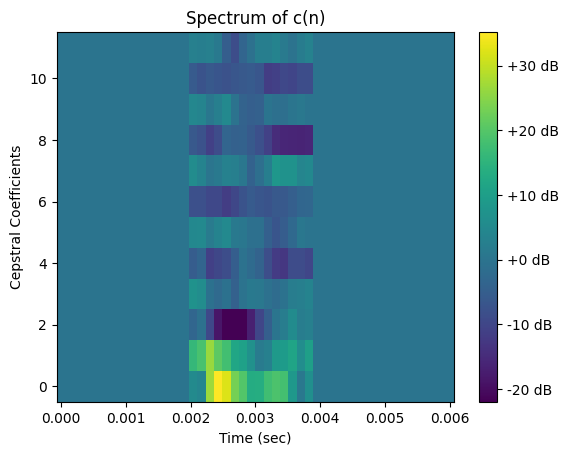

In [13]:
"""
Run this block to check some of the outputs from the block above
"""
check_output = True
if check_output:
    print(l_train_labels.shape)
    print(l_dev_set_labels)

    t_time = nn_data_cols / fs
    data = np.resize(train_set[101],(nn_data_rows, nn_data_cols))
    t = np.linspace(0, t_time, nn_data_cols)
    n = np.arange(nn_data_rows)
    plt.title("Spectrum of c(n)")
    plt.ylabel("Cepstral Coefficients")
    plt.xlabel("Time (sec)")
    plt.pcolormesh(t, n, data)
    plt.colorbar(format="%+2.f dB")

In [14]:
def compute_accuracies(predicted_labels, dev_set, dev_labels):
    yhats = predicted_labels
    # np.int was deprecated in latest versions
    # assert predicted_labels.dtype == np.int, "Your predicted labels have type {}, but they should have type np.int (consider using .astype(int) on your output)".format(predicted_labels.dtype)
    assert predicted_labels.dtype == int, "Your predicted labels have type {}, but they should have type np.int (consider using .astype(int) on your output)".format(predicted_labels.dtype)

    if len(yhats) != len(dev_labels):
        print("Lengths of predicted labels don't match length of actual labels", len(yhats), len(dev_labels))
        return 0., 0., 0., 0.
    accuracy = np.mean(yhats == dev_labels)
    conf_m = np.zeros((len(np.unique(dev_labels)),len(np.unique(dev_labels))))
    for i,j in zip(dev_labels,predicted_labels):
        conf_m[i,j] +=1

    return accuracy, conf_m

def get_parameter_counts(net):
    """ Get the parameters of your network
    @return params: a list of tensors containing all parameters of the network
            num_params: count of the total number of parameters
    """
    params = net.parameters()
    num_parameters = sum([ np.prod(w.shape) for w  in params])

    return num_parameters,params

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X,y):
        """
        Args:
            X [np.array]: features vector
            y [np.array]: labels vector          
        """
        self.data = X
        self.labels = y

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        features = self.data[idx,:]
        label = self.labels[idx]
        sample = {'features': features,'labels': label}
        return sample

class NeuralNet(nn.Module):
    def __init__(self, lrate, in_size, out_size, mfcc_dim, loss_fn=nn.CrossEntropyLoss(), weight_decay=0.01):
        """
        Initializes the layers of your neural network.

        @param lrate: learning rate for the model
        @param loss_fn: A loss function defined as follows:
            @param yhat - an (N,out_size) Tensor
            @param y - an (N,) Tensor
            @return l(x,y) an () Tensor that is the mean loss
        @param in_size: input dimension
        @param out_size: output dimension

        For Part 1 the network should have the following architecture (in terms of hidden units):

        in_size -> h ->  out_size , where  1 <= h <= 256
        
        We recommend setting lrate to 0.01 for part 1.

        """
        super(NeuralNet, self).__init__()
        # define layers for music classification 
        self.mfcc_dim = mfcc_dim

        kernel_size = (3,3)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=kernel_size, stride=1, padding=1, device=device)
        self.maxpool = nn.MaxPool2d(kernel_size=kernel_size, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=kernel_size, stride=1, padding=1, device=device)
        self.dropout_1 = nn.Dropout(p=0.1)
        self.dropout_2 = nn.Dropout(p=0.16)
        self.dropout_3 = nn.Dropout(p=0.12)
        self.relu = nn.ReLU()

        self.model = nn.Sequential(self.conv1, nn.ReLU6(), self.maxpool, self.conv2, nn.ReLU6(), self.maxpool, self.dropout_1)


        self.linear_1 = nn.Linear(in_features=20*mfcc_dim[0]*mfcc_dim[1], out_features=5000)
        self.linear_2 = nn.Linear(in_features=5000, out_features=1000)
        self.linear_3 = nn.Linear(in_features=1000, out_features=out_size)

        # self.model_2 = nn.Sequential(self.linear_1, self.dropout_2, self.linear_2, self.dropout_3, self.linear_3)

        self.loss_fn = loss_fn
        self.double()

        self.optimizer = optim.SGD(self.parameters(), lr=lrate, weight_decay=weight_decay)

    def conv_out_size(self, inp_size, kernel_size, dilation, padding, stride):
        return ((inp_size + 2*padding - dilation * (kernel_size - 1) - 1) // stride) + 1
    

    def forward(self, x):
        """Performs a forward pass through your neural net (evaluates f(x)).

        @param x: an (N, in_size) Tensor
        @return y: an (N, out_size) Tensor of output from the network
        """
        x = x.view(x.shape[0], 1, self.mfcc_dim[0], self.mfcc_dim[1])
        x = self.model(x)
        x = x.view(x.shape[0], 20*self.mfcc_dim[0]*self.mfcc_dim[1])
        # x = self.model_2(x)
        # print("shape x before l1: {}".format(x.shape))
        x = self.linear_1(x)
        x = self.dropout_2(x)
        # print("shape x before l2: {}".format(x.shape))
        x = self.linear_2(x)
        x = self.dropout_3(x)
        # print("shape x before l3: {}".format(x.shape))
        x = self.linear_3(x)

        return x

    def step(self, x,y):
        """
        Performs one gradient step through a batch of data x with labels y.

        @param x: an (N, in_size) Tensor
        @param y: an (N,) Tensor
        @return L: total empirical risk (mean of losses) for this batch as a float (scalar)
        """
        # raise NotImplementedError("You need to write this part!")
        x = x.to(device)
        y = y.to(device)

        # zero out the optimizer
        self.optimizer.zero_grad()

        # pass the batch through the model
        y_hat = self.forward(x)
        # compute the lost
        loss = self.loss_fn(y_hat, y)

        # update model
        loss.backward()
        self.optimizer.step()
        return loss.cpu().item()
        return loss.item()
        return loss.detach().cpu().numpy()



def fit(in_size, out_size,train_set,train_labels,dev_set,epochs,batch_size=100, lrate=1e-6, weight_decay=0.01):
    """ Make NeuralNet object 'net' and use net.step() to train a neural net
    and net(x) to evaluate the neural net.

    @param train_set: an (N, in_size) Tensor
    @param train_labels: an (N,) Tensor
    @param dev_set: an (M,) Tensor
    @param epochs: an int, the number of epochs of training
    @param batch_size: size of each batch to train on. (default 100)

    This method _must_ work for arbitrary M and N.

    The model's performance could be sensitive to the choice of learning rate.
    We recommend trying different values in case your first choice does not seem to work well.

    @return losses: list of floats containing the total loss at the beginning and after each epoch.
            Ensure that len(losses) == epochs.
    @return yhats: an (M,) NumPy array of binary labels for dev_set
    @return net: a NeuralNet object
    """
    # raise NotImplementedError("You need to write this part!")
    # print(len(train_labels))
    # print(train_set)
    # print(train_labels)
    # print(dev_set)
    
    u = train_set.mean()
    a = train_set.std()

    norm_set = (train_set-u)/a
    norm_dev = (dev_set-u)/a
    # data = MyDataset(norm_set, train_labels)
    data = MyDataset(train_set, train_labels)
    data = DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=False)

    # lrate, in_size, out_size, mfcc_dim, loss_fn=nn.CrossEntropyLoss()
    NetObject = NeuralNet(lrate, in_size, out_size, mfcc_dim=(12,48), loss_fn=nn.CrossEntropyLoss(), weight_decay=weight_decay)
    NetObject.to(device)

    losses = []
    for epoch in range(epochs):
        print("\rEpoch {}".format(epoch), end="")
        epoch_loss = 0.0
        for batch in data:
            batch_x, batch_y = batch
            # print("batch x size: {}".format(batch[batch_x].dtype))
            # print("batch y size: {}".format(batch[batch_y].dtype))
            epoch_loss += NetObject.step(batch[batch_x], batch[batch_y])
        epoch_loss /= len(data)

        losses.append(epoch_loss)

    ytemp = np.zeros((len(dev_set), out_size))
    with torch.no_grad():
        # ytemp = NetObject.forward(norm_dev).detach().cpu().numpy()
        ytemp = NetObject.forward(dev_set.to(device)).detach().cpu().numpy()
        # for i in range(len(dev_set)):
        #     # dev = dev_set[i]
        #     dev = norm_dev[i]
        #     dev = Variable(dev.view(-1, seq_dim, in_size)).requires_grad_().to(device)
        #     ret_val = NetObject.forward(dev).detach().numpy()
        #     # print(ret_val)
        #     ytemp[i] = ret_val
        
    # print(ytemp)
    
    predicted_labels = []
    for i in range(len(ytemp)):
        idx = np.argmax(ytemp[i]).astype(int)
        predicted_labels.append(idx)

    predicted_labels = np.array(predicted_labels)
        
    return losses,predicted_labels,NetObject

In [15]:
batch_size = 64
epochs = 30
input_dim = 12 # num ceps - 1
output_dim = 10 # number of genres
weight_decay = 1e-2
learning_rate = 1e-2

# convert numpys to torches
train_set = torch.tensor(train_set, dtype=torch.float64)
l_train_labels = torch.tensor(l_train_labels, dtype=torch.int64)
dev_set = torch.tensor(dev_set, dtype=torch.float64)
# dev_set_labels = torch.tensor(dev_set_labels)

In [16]:
# fit data
# in_size, out_size,train_set,train_labels,dev_set,epochs,batch_size=100
# learning_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]
# weight_decays = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]
# combinations = []
# accuracies = []
# confusion_matrices = []
# notable_accuracies = []
# for weight_decay in weight_decays:
#     for learning_rate in learning_rates:

L, predicted_labels, net = fit(input_dim, output_dim, train_set,l_train_labels,dev_set,epochs,batch_size,lrate=learning_rate, weight_decay=weight_decay)

assert type(predicted_labels) == np.ndarray, "your fit function returned the predicted labels as {} instead of np.ndarray. Make sure to use .detach().cpu().numpy() on the network output - and don't forget to argmax it!".format(type(predicted_labels))
assert type(L) == list,"your fit function returned the losses as {} instead of list. Make sure you are returning a list of losses (with length equal to the number of epochs)".format(type(L))

accuracy, conf_m = compute_accuracies(predicted_labels, dev_set, l_dev_set_labels)
# combinations.append((learning_rate, weight_decay))

# accuracies.append(accuracy)
# confusion_matrices.append(conf_m)
# if accuracy > 0.5:
#     notable_accuracies.append(accuracy)

print("\n Accuracy:", accuracy)
print("\nConfusion Matrix = \n {}".format(conf_m))
num_parameters,params = get_parameter_counts(net)
print('\nparameters = {} \n'.format(num_parameters))

: 

: 

In [ ]:
# print(notable_accuracies)

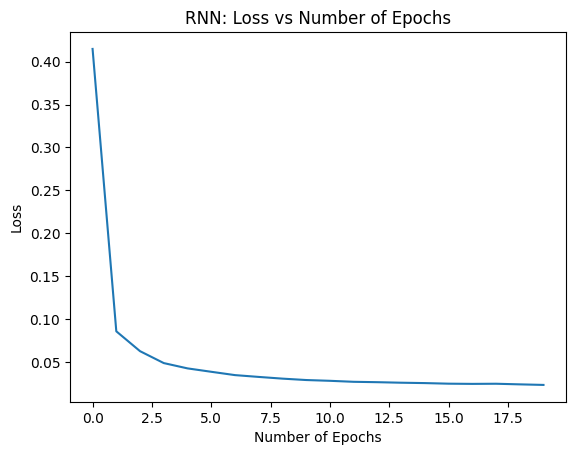

In [ ]:
iterations = [i for i in range(epochs)]
plt.plot(iterations, L)
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("RNN: Loss vs Number of Epochs")
plt.show()

In [ ]:
# saving a model
# torch.save(net.state_dict(),'second_model_run.pth')

In [ ]:
# # loading the pytorch model
# net = NeuralNet(0.01, input_dim, output_dim, mfcc_dim=(12,48), loss_fn=nn.CrossEntropyLoss())
# net.load_state_dict(torch.load('second_model_run.pth'))
# net.eval()

In [ ]:
# song_path = "AudioMNIST/data/60/3_60_8.wav"
song_path = "nine_voice_test.wav"
y, s = librosa.load(song_path, sr=8000)
print(len(y))
print(s)
fs, music_stereo = wavfile.read(song_path) # Import the sound file
print(len(music_stereo))
print(fs)
fs = s
music_stereo = y
# Audio(music_stereo, rate=fs)
Audio(y, rate=s)

3994
8000
3994
8000


In [ ]:
ceps = np.array(myMatrix.MFCC_Matrix(list(music_stereo), fs, nfft, noverlap, 2, 0.6, nfilt, num_ceps), copy=False)
ceps = ceps[1:,:]
processed_wav = ceps
# fix dimensions if necessary
print("Original number of time frames: {}".format(ceps.shape[1]))
# if len(processed_wav) > nn_data_cols*nn_data_rows:
#         processed_wav = processed_wav[:nn_data_cols*nn_data_rows]
# elif len(processed_wav) < nn_data_cols*nn_data_rows:
#     processed_wav = np.append(processed_wav, np.zeroes(nn_data_cols*nn_data_rows - len(processed_wav)))
if processed_wav.shape[0]*processed_wav.shape[1] > nn_data_cols*nn_data_rows:
        processed_wav = processed_wav[:nn_data_cols*nn_data_rows]
elif processed_wav.shape[0]*processed_wav.shape[1] < nn_data_cols*nn_data_rows:
    extended_sig = np.zeros((nn_data_rows,nn_data_cols))
    for row in range(nn_data_rows):
        for col in range(processed_wav.shape[1]):
            extended_sig[row][col] = processed_wav[row][col]
    processed_wav = extended_sig.ravel()
else:
    processed_wav = processed_wav.ravel()
# create data array for spectogram
data = np.resize(processed_wav, (nn_data_rows, nn_data_cols))
# turn to tensor
test_file = np.zeros((1, nn_data_cols*nn_data_rows))
test_file[0] = processed_wav
test_file = torch.tensor(test_file, dtype=torch.float64)
# check prediction
u = train_set.mean()
a = train_set.std()
test_file = (test_file-u)/a
result = net.forward(test_file.to(device)).detach().cpu().numpy()[0]
print(result)
first_place = np.argmax(result).astype(int)
print("1st: {}".format(first_place))
result[first_place] = -10

second_place = np.argmax(result).astype(int)
print("2nd: {}".format(second_place))
result[second_place] = -10

third_place = np.argmax(result).astype(int)
print("3rd: {}".format(third_place))

Original number of time frames: 14
[ 2.51761375e-02  3.56667566e-01 -8.70650583e-01 -7.89363288e-01
 -8.82860864e-04  5.13788204e-01 -9.46453274e-01  4.67090632e-01
  5.78058931e-02  1.22510330e+00]
1st: 9
2nd: 5
3rd: 7


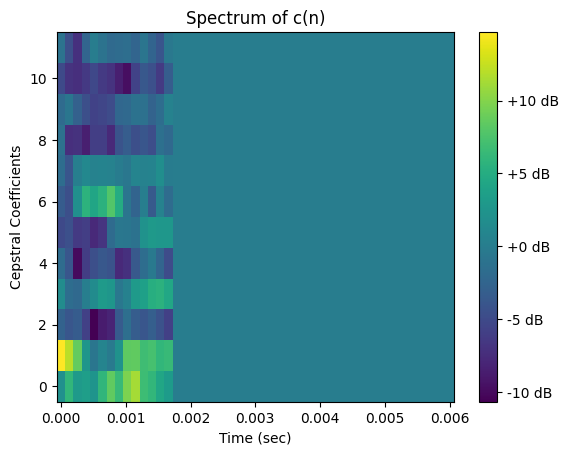

In [ ]:
t_time = nn_data_cols / fs
t = np.linspace(0, t_time, nn_data_cols)
n = np.arange(nn_data_rows)
plt.title("Spectrum of c(n)")
plt.ylabel("Cepstral Coefficients")
plt.xlabel("Time (sec)")
plt.pcolormesh(t, n, data)
plt.colorbar(format="%+2.f dB")